## NLP TWITTER ANALYSIS

* Final Project Submission
* Group Members
   1. Benson Kamau
   2. Kevin Muchori
   3. Nancy Chelangat
   4. Sally Kinyanjui
   5. Breden Mugambi

* Student Pace: Full-Time
* Instructor's: Nikita Njoroge

### Problem Statement
Accurately classifying the sentiments expressed in tweets about topics or brands into specific classes- positive, negative or neutral is a huge challenge for companies like Apple and Google. Given the diverse nature of informal data, with its use of slang, abbreviations, coming up with a reliable sentiment analysis model that can effectively interpret and classify the tweets can be a complex task. Getting this task right provides a wide variety of novel information for a company like Apple by providing insights and creating better understanding overall of how consumers interact with products/brands.

### Objective
The main objective is to build a model that can rate the sentiment of  a tweet based on its content.

#### Project Success Metrics
Over 75% accuracy on the testing data.

#### Importing relavent Libraries

In [1]:
import re
import nltk
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from string import punctuation
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.tokenize import regexp_tokenize, word_tokenize,TweetTokenizer, RegexpTokenizer





In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1. Data Loading and Understanding

The dataset that will be used in this study comes from CrowdFlower via data.world through this link - https://data.world/crowdflower/brands-and-product-emotions.


In [3]:
#create a function that loads data and gets the info about the data.
def load_and_get_info(file_path, encoding='utf-8'):
    try :
        # Load data
        df = pd.read_csv(file_path, encoding=encoding)

        # Display the first few rows of the DataFrame
        df_head = df.head()

        # Get information about the DataFrame
        df_info = df.info()

        return df,df_info, df_head
    except UnicodeDecodeError:
        print(f"Failed to decode {file_path} with encoding {encoding}. Trying with 'latin1' encoding.")
        return load_and_get_info(file_path, encoding='latin1')

# A function that checks the data types of DataFrame columns and return the count of columns for each data type category.
def check_data_types(df):

    data_type_counts = df.dtypes.replace({'object': 'string'}).value_counts().to_dict()
    return data_type_counts

In [4]:
file_path1 = 'tweet-analysis.csv'
df1,data_info, data_head = load_and_get_info(file_path1)
print(data_info)
print("\nFirst few rows of the DataFrame:")
data_head #data_head

Failed to decode tweet-analysis.csv with encoding utf-8. Trying with 'latin1' encoding.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None

First few rows of the DataFrame:


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset contains the following columns:

1. 'tweet_text' column
    - Contains the text of the tweet.
2. 'emotion_in_tweet_is_directed_at' column
    - Contains the person or entity that the tweet is directed at.
3. 'is_there_an_emotion_directed_at_a_brand_or_product' column
    - Indicates the kind of emotion in the tweet directed at the brand or product

The dataset has a total of 9093 data points.



In [5]:
#check the data types of DataFrame columns in our training set values.
data_type_counts = check_data_types(df1)
print("Count of columns for each data type category:")
print(data_type_counts)

Count of columns for each data type category:
{'string': 3}


The dataset has one data type category .i., object type.


To simplify working with the dataset, we will rename the columns to simpler and shorter names.


In [6]:
# function to rename the column names
def rename_columns(df, columns_dict):
    """
   Parameters:
    df (pd.DataFrame): The DataFrame whose columns need to be renamed.
    columns_dict (dict): A dictionary where keys are current column names and values are the new column names.
    """
    df.rename(columns=columns_dict, inplace=True)
    return df

# Define the dictionary for renaming columns
columns_dict = {
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'target_entity',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
}

# Rename columns using the dictionary
df1 = rename_columns(df1, columns_dict)

print("\nRenamed DataFrame columns:")
print(df1.columns)
df1.head()


Renamed DataFrame columns:
Index(['tweet', 'target_entity', 'emotion'], dtype='object')


,tweet,target_entity,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


The dataset has been successfully renamed and the column names are now more descriptive.

# Data Cleaning
This is an essential aspect so as to ensure that the text data is consistent and free of errors. For this project, we will check for missing values, checking for duplicates,
remove white spaces, handle capitalization.



In [7]:
# Check missing values
df1.isna().sum()

tweet               1
target_entity    5802
emotion             0
dtype: int64

There is only one missing tweet text value, which will be removed. There are 5,802 missing "target_entity" values; however, this is acceptable since the current project focuses on overall tweet sentiment rather than specific items. These missing values will be replaced with an "Uncategorized" classification.

In [8]:
#Removing Null Tweets, Removing Duplicate entries and Filling in missing Item Values

#Removing 1 null 'Tweet' Entry
df1.dropna(subset = ['tweet'], inplace=True)

#Removing Duplicates
df1.drop_duplicates(inplace=True)

#Filling in Null "Item" categories with "Uncategorized"
df1['target_entity'].fillna('Uncategorized', inplace=True)

df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9070 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet          9070 non-null   object
 1   target_entity  9070 non-null   object
 2   emotion        9070 non-null   object
dtypes: object(3)
memory usage: 283.4+ KB


At this point there should not be any duplicate entries or null values in the data and the total row count in the dataset has decreased from 9092 to 9070.

Text Cleaning: The function below cleans the tweet column by removing white spaces, converting to lower case, and removing special characters.

In [9]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = text.lower()
    pattern = re.compile(r'[^a-zA-Z0-9\s]')
    text = pattern.sub('', text)
    return text

# Apply the clean_text function to the tweet column
df1['cleaned_tweet'] = df1['tweet'].apply(clean_text)
df1.head()

,tweet,target_entity,emotion,cleaned_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...


The additional column cleaned_tweet stores the text after text cleaning.

## Lemmatization ,stop word removal and tokenization

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# function to lemmatize text
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply the lemmatize_text function to the 'cleaned_tweet' column
df1['lemmatized_tweet'] = df1['cleaned_tweet'].apply(lemmatize_text)

df1.head(10)




,tweet,target_entity,emotion,cleaned_tweet,lemmatized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,wesley83 i have a 3g iphone after 3 hr tweetin...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphon...,jessedee know about fludapp awesome ipadiphone...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,sxsw i hope this year festival isnt a crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,sxtxstate great stuff on fri sxsw marissa maye...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Uncategorized,No emotion toward brand or product,teachntech00 new ipad apps for speechtherapy a...,teachntech00 new ipad apps for speechtherapy a...
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,sxsw is just starting ctia is around the corne...,sxsw is just starting ctia is around the corne...
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,beautifully smart and simple idea rt madebyman...,beautifully smart and simple idea rt madebyman...
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,counting down the days to sxsw plus strong can...,counting down the day to sxsw plus strong cana...
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,excited to meet the samsungmobileus at sxsw so...,excited to meet the samsungmobileus at sxsw so...


WordNetLemmatizer() is used to reduce words to their base or root form. This is what is known as lemmatization.

This function def lemmatize_text(text)  tokenizes the input text into words,lemmatizes each word and joins the lemmatized words back into a string.

From the output , the original tweet is the raw tweet text,the cleaned  tweet is the twwet after preprocessing  and the lemmatized tweet is the cleaned twwet after lemmatization.

In [11]:
# Load the stop words
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In the input, english indicates that the output required is supposed to be a setg of English stop words.

This set of stop words can be used in text preprocessing tasks

In [12]:
def preprocess_text_nltk(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    r_stop_words = [word for word in tokens if word.lower() not in stop_words]


# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# function to lemmatize text
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply the lemmatize_text function to the 'cleaned_tweet' column
df1['lemmatized_tweet'] = df1['cleaned_tweet'].apply(lemmatize_text)
df1.head(10)

,tweet,target_entity,emotion,cleaned_tweet,lemmatized_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...,wesley83 i have a 3g iphone after 3 hr tweetin...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipadiphon...,jessedee know about fludapp awesome ipadiphone...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad 2 also they s...,swonderlin can not wait for ipad 2 also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this years festival isnt as crashy...,sxsw i hope this year festival isnt a crashy a...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,sxtxstate great stuff on fri sxsw marissa maye...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,Uncategorized,No emotion toward brand or product,teachntech00 new ipad apps for speechtherapy a...,teachntech00 new ipad apps for speechtherapy a...
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,sxsw is just starting ctia is around the corne...,sxsw is just starting ctia is around the corne...
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,beautifully smart and simple idea rt madebyman...,beautifully smart and simple idea rt madebyman...
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,counting down the days to sxsw plus strong can...,counting down the day to sxsw plus strong cana...
10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,excited to meet the samsungmobileus at sxsw so...,excited to meet the samsungmobileus at sxsw so...


Similar to lemmatization,both functions play the same role .

The function 'def preprocess_text_nltk(text)' is used to tokenize the text.

In [13]:
# Function to tokenize and remove stopwords and punctuation
def process_tweet(tweet):
    tweet = tweet.lower() #convert tweet to lowercase
   # for
    pattern = r"\b\w+(?:'\w+)?\b"
    # Create a RegexpTokenizer with the defined pattern
    tokenizer = RegexpTokenizer(pattern)
    # Tokenize tweet
    tokens = tokenizer.tokenize(tweet)
    tokens = [token for token in tokens if token not in stopwords.words('english')
              and token not in punctuation]
    return tokens


Pattern r"\b\w+(?:'\w+)?\b"  used for tokenizing text while keeping words with apostrophes. Below is an example.

In [14]:
import re
from nltk.tokenize import RegexpTokenizer

# Define the pattern
pattern = r"\b\w+(?:'\w+)?\b"

# Create a RegexpTokenizer with the pattern
tokenizer = RegexpTokenizer(pattern)

# Example tweet
tweet = "I'm excited about the iPhone's new features! Isn't it amazing?"

# Tokenize the tweet
tokens = tokenizer.tokenize(tweet)

# Print the tokens
print(tokens)


["I'm", 'excited', 'about', 'the', "iPhone's", 'new', 'features', "Isn't", 'it', 'amazing']


This output shows that the tokenizer breaks dwon the tweet into components,and handling even  shortened words and ownership accurately.

In [15]:
df1.sample(10)

,tweet,target_entity,emotion,cleaned_tweet,lemmatized_tweet
2113,RT SteveCase: Google to Launch Major New Socia...,Uncategorized,No emotion toward brand or product,rt stevecase google to launch major new social...,rt stevecase google to launch major new social...
4423,RT@mention Google to Launch Major New Social N...,Uncategorized,Positive emotion,rtmention google to launch major new social ne...,rtmention google to launch major new social ne...
8921,Anyone down at #SXSW wanna bring me back a Win...,Uncategorized,No emotion toward brand or product,anyone down at sxsw wanna bring me back a wind...,anyone down at sxsw wan na bring me back a win...
5575,RT @mention Biomimicry as the basis of design ...,Google,Positive emotion,rt mention biomimicry as the basis of design a...,rt mention biomimicry a the basis of design an...
5547,"RT @mention Before it even begins, Apple wins ...",Apple,Positive emotion,rt mention before it even begins apple wins sx...,rt mention before it even begin apple win sxsw...
4441,RT@mention Love it. @mention at #sxsw: &quot;a...,Apple,Positive emotion,rtmention love it mention at sxsw quotapple co...,rtmention love it mention at sxsw quotapple co...
651,I have no idea why this startupbus thing is so...,Android App,Positive emotion,i have no idea why this startupbus thing is so...,i have no idea why this startupbus thing is so...
6142,RT @mention iPad 2 Contest- Join actsofsharing...,Uncategorized,No emotion toward brand or product,rt mention ipad 2 contest join actsofsharingco...,rt mention ipad 2 contest join actsofsharingco...
2954,#UXdes @mention is glad there are no standard ...,Uncategorized,I can't tell,uxdes mention is glad there are no standard ip...,uxdes mention is glad there are no standard ip...
2819,I am amused at the Apple Pop-up store at #SXSW...,Apple,Positive emotion,i am amused at the apple popup store at sxsw t...,i am amused at the apple popup store at sxsw t...


Compared to other outputs this one right here differs from the rest becuase here we used sample and the samples of the rows we printed might containtweets with varying characteristicss.

In [16]:
df1['target_entity'].fillna('Uncategorized', inplace=True)
df1['target_entity'].value_counts()

target_entity
Uncategorized                      5788
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64

EDA

In [17]:
def count_words(text):
  """Counts the number of words in a given text."""
  words = text.split()
  return len(words)

In [18]:
df1['word_count'] = df1['tweet'].apply(count_words)
df1['word_count'].describe()


count    9070.000000
mean       17.765932
std         4.962136
min         2.000000
25%        14.000000
50%        18.000000
75%        21.000000
max        33.000000
Name: word_count, dtype: float64

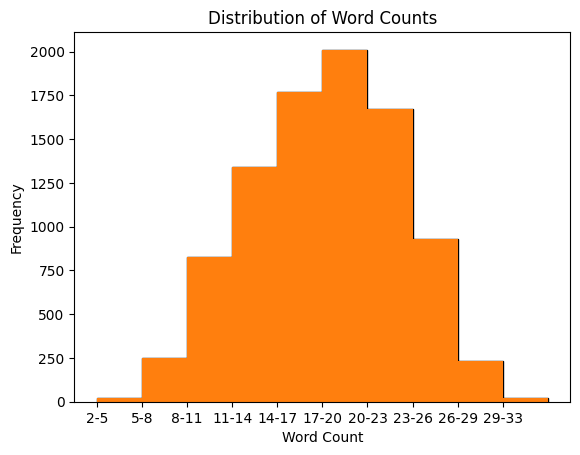

In [19]:
# Histogram
plt.hist(df1['word_count'], bins=10, edgecolor='black')

# Calculate bin edges
counts, bins, patches = plt.hist(df1['word_count'], bins=10)

# Create bin labels
bin_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]

# Set x-axis labels
plt.xticks(bins[:-1], bin_labels)

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts')
plt.show()

<Figure size 1200x600 with 0 Axes>

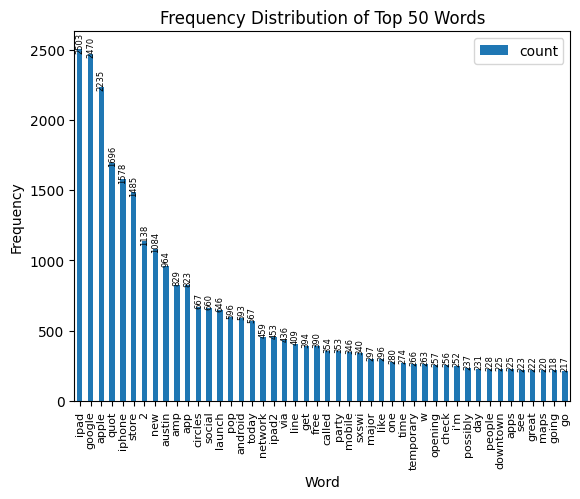

In [33]:
from collections import Counter

df1['tokenized_tweets'] = df1['tweet'].apply(process_tweet)

all_words = [word for sublist in df1['tokenized_tweets'] for word in sublist]

# Calculate word frequencies
word_counts = Counter(all_words)

# Convert word counts to a DataFrame
word_freq_df = pd.DataFrame(word_counts.items(), columns=['word', 'count'])

# Sort by frequency
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)


# Visualize the top 20 words
plt.figure(figsize=(12, 6))
ax = word_freq_df[4:50].plot(x='word', y='count', kind='bar')

for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points',
                fontsize=6,  # Adjust font size here
                rotation=90)  # Adjust rotation here

#word_freq_df[:40].plot(x='word', y='count', kind='bar')
plt.title('Frequency Distribution of Top 50 Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(
    rotation = 90,
    fontsize = 8)
plt.show()

In [21]:
word_freq_df.describe()

,count
count,9831.000000
mean,11.760859
std,144.766248
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,9593.000000


wordcloud

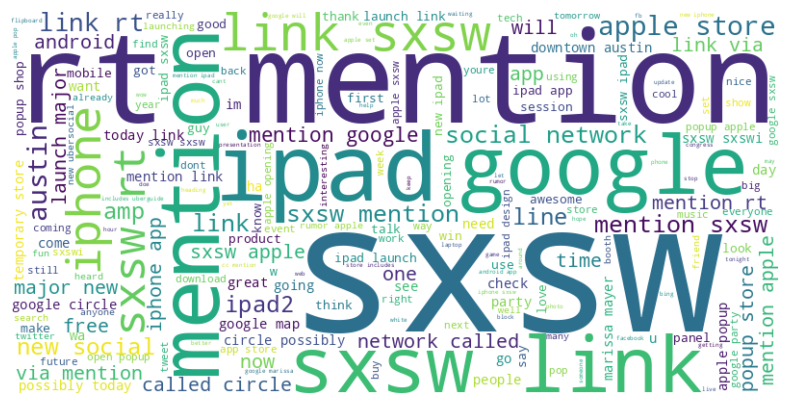

In [38]:
from wordcloud import WordCloud

text = ' '.join(df1['lemmatized_tweet'].astype(str))
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

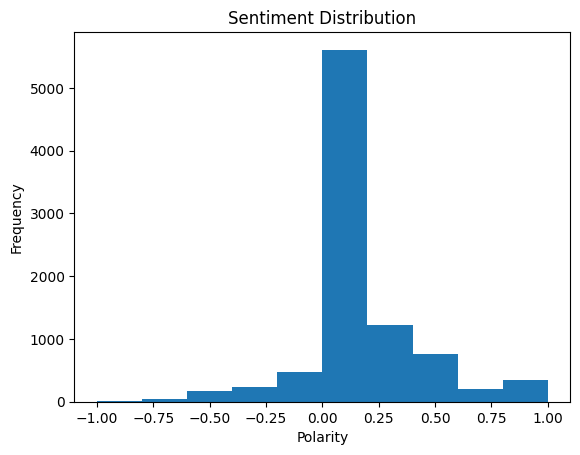

In [43]:
from textblob import TextBlob

df1['polarity'] = df1['lemmatized_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment distribution
plt.hist(df1['polarity'], bins=10)
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


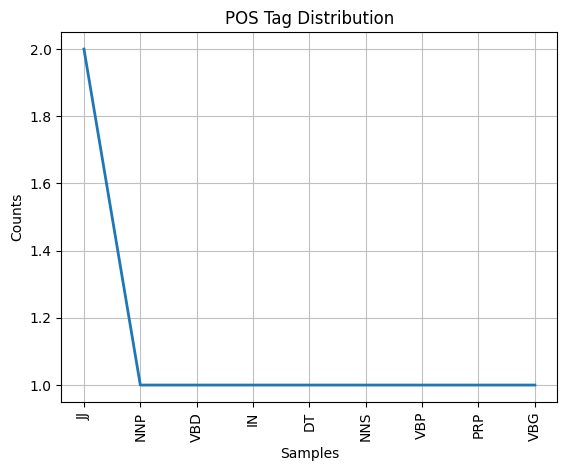

<Axes: title={'center': 'POS Tag Distribution'}, xlabel='Samples', ylabel='Counts'>

In [31]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

df1['tokenized_tweets'] = df1['tweet'].apply(process_tweet)

df1['tokenized_tweets'] = df1['tokenized_tweets'].apply(' '.join)
tagged = pos_tag(tokens)

# Extract POS tags
pos_tags = [tag[1] for tag in tagged]

# Count POS tag frequencies
fdist = nltk.FreqDist(pos_tags)

# Plot POS tag distribution
#plt.figure(figsize=(10, 5))
plt.title('POS Tag Distribution')
fdist.plot()
#plt.title('POS Tag Distribution')
#plt.show()

devices section

In [46]:
df1['target_entity'].describe()

count              9070
unique               10
top       Uncategorized
freq               5788
Name: target_entity, dtype: object

<Axes: title={'center': 'Target Entity Distribution'}, xlabel='Target Entity', ylabel='Frequency'>

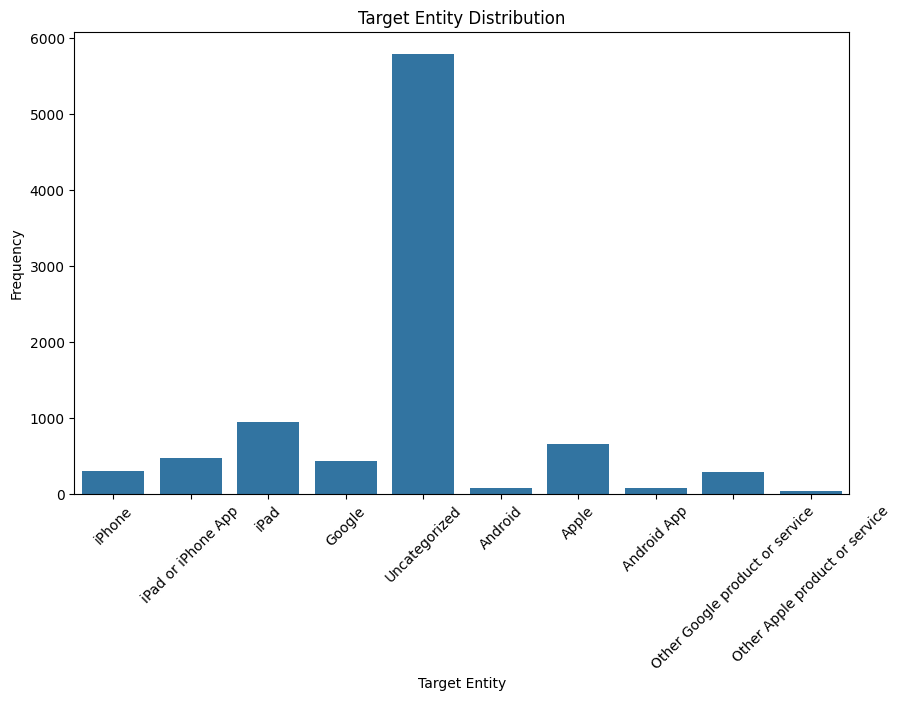

In [50]:
plt.figure(figsize=(10, 6))
plt.title('Target Entity Distribution')
plt.xticks(rotation = 45)
plt.xlabel('Target Entity')
plt.ylabel('Frequency')
sns.countplot(x='target_entity', data=df1)

In [51]:
df1['emotion'].value_counts()

emotion
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

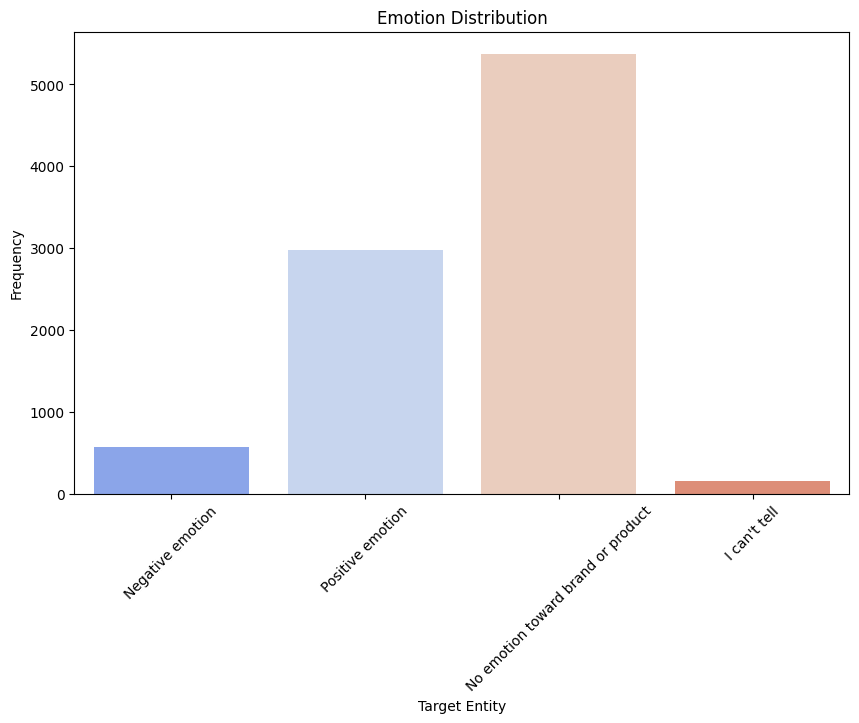

In [57]:
plt.figure(figsize=(10, 6))
plt.title('Emotion Distribution')
plt.xticks(rotation = 45)
plt.xlabel('Target Entity')
plt.ylabel('Frequency')
sns.countplot(x='emotion', data=df1, palette = 'coolwarm')

plt.show()